# 1. Introducció
En aquest notebook es tractarà el cas de Kaggle: **[Melbourne Housing Market](https://www.kaggle.com/anthonypino/melbourne-housing-market)**

El dataset de Kaggle en el què es centra aquest treball conté dades dels habitatges venuts a la ciutat de Melbourne, Austràlia, entre els anys 2016 i 2018. 
L objectiu del treball amb aquest dataset són dos. Per una banda, aprendre a gestionar i resoldre les mostres incompletes per poder aprofitar la major quantitat de mostres possibles. 
La segona, crear models regressors que permetin predir  el preus  de venda per als habitatges que es posaran al mercat en el futur a la ciutat de Melbourne.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import model_selection
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import statistics
from matplotlib.legend_handler import HandlerLine2D
from joblib import dump, load
from sklearn.model_selection import RandomizedSearchCV
from random import randint
import warnings
warnings.filterwarnings('ignore')

# 2.Preprocessat dades
Per tal de poder utilitzar les dades del dataset per a entrenar models cal abans assegurar que són adequades per la tasca. En un primer moment cal conèixer el dataset.

In [2]:
def load_dataset(path):
    return pd.read_csv(path, header=0, delimiter=",")
dataset = load_dataset("/home/alexandre/Desktop/APC/Cas Kaggle/APC_Kaggle21/data/Melbourne_housing_FULL.csv")
data = dataset.values

x_housing= data[:, :-1]
y_housing = data[:, -1]
print("Dimensionalitat de la BBDD_housing:", dataset.shape)
print(dataset.head())

Dimensionalitat de la BBDD_housing: (34857, 21)
       Suburb             Address  Rooms Type      Price Method SellerG  \
0  Abbotsford       68 Studley St      2    h        NaN     SS  Jellis   
1  Abbotsford        85 Turner St      2    h  1480000.0      S  Biggin   
2  Abbotsford     25 Bloomburg St      2    h  1035000.0      S  Biggin   
3  Abbotsford  18/659 Victoria St      3    u        NaN     VB  Rounds   
4  Abbotsford        5 Charles St      3    h  1465000.0     SP  Biggin   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/09/2016       2.5    3067.0  ...       1.0  1.0     126.0           NaN   
1  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
2  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
3  4/02/2016       2.5    3067.0  ...       2.0  1.0       0.0           NaN   
4  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   

   YearBuilt        

### Tipus d'atributs:
- Suburb: suburbi
- Address: Addreça
- Rooms: Num. d'habitacions
- Price: Preu en Australian dollars
- Method: mètode de venda
- Type:tipus immoble
- SellerG: Real Estate Agent
- Date: data de venda
- Distance: distància al centre in Kilometres
- Regionname: General Region (
- Propertycount: nombre d'immobles al suburbi
- Bedroom2 : num. dormitoris
- Bathroom: num. banys
- Car: num places cotxe
- Landsize: superficie terreny en Metres
- BuildingArea: superficie edificable Metres
- YearBuilt: any construcció
- CouncilArea: concell de govern de la zona
- Lattitude
- Longtitude

Analitzem la l'existència de valors null en les dades:

In [3]:
print(dataset.isnull().sum())

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64


Com es pot observar les mostres presenten una gran heterogeneïtat pel què fa a les característiques que tenen registrades (sense valors null). En alguns atributs com BuildingArea o YearBuilt, 66% de les 
mostres tenen Nan en aquestes caracterísitques. Per la resta d'atributs també hi ha una gran presencia de valors null. Només  un 25% de les mostres contenen tota la informació als atributs. 

Cal aplicar un tractament profund de les dades per substituir els Nan i o eliminar files.

### Funcions de tractament de Nans aplicades:
1. **def find_location(dataset)**: substitueix Nans de lattitide i longtitude per la mitjana del suburbi en qüestió.
2. **def find_yearBuilt_and_landsize(dataset)**: substitueix Nans de de yearBuilt i landsize per la mitjana del suburbi en qüestió.
3. **def remove_rows_Nan_price_bed_bath_car(dataset)**: suprimerix del dataset les mostres amb Nans a l'atribut price, bedroom2, bath o car.
4. **def codifica_type(dataset)**: converteix en nous atributs (binaris) els possibles valors d'aquesta caracterísitca.
5. **def codifica_method(dataset)**: converteix en nous atributs (binaris) els possibles valors d'aquesta caracterísitca.
6. **def select_year_From_date(date)**: redueix l'atribut a l'any.
7. **def convert_sellerG (dataset)**: substitueix aquest atribut per una distribució binària entre tres nous (big,medium,small) per agrupar els venedors en tres grups posibles.
8. **def remove_rows_BuildingArea(dataset)**: elimina les mostres sense dades en aquest atribut.
9. **def actualize_inflation_price(dataset)**: actualitza el valor del preu de venda de les cases anteriors a l'any 2018 als presu d'aquell any 2018 en funció de la inflació experimentada a Austràlia entre aquells anys per equiparar les dades.

A més s'ha identifificat 7 atributs que aportaven informació redundant ja que d'una forma o altra descrivien la localització dels immobles. Es tracta dels atributs: 'Suburb','Address','Postcode','CouncilArea','Latitude','Longitude', 'Regionname'. D'entre aquests, s'ha considerat que Lattitude i Longtitude eren els atributs que més convenienment donaven la localització ja que són numèrics i a diferència de l'altre numèric, Postcode, són únics (a excepció dels pisos). Així doncs, s'ha optat per eliminar els 5 atributs amb informació redundant.  

In [4]:
dataset = dataset.drop(['Suburb','Address','Postcode','CouncilArea','Regionname'],axis=1)

El resultat del tractament dels Nans del dataset s'ha emmagatazemant en un nou dataset per tal d'estalviar el cost computacional del tractament en cada execució.

La càrrega del dataset original o del tractat es pot especificar amb la segënt funció:

In [5]:
def choose_dataset(which_one):
    if which_one == 'EDA':
        dataset = load_dataset("../data/little__db_linia_324.csv")
        atributs = dataset.columns.tolist()
        aux = atributs[3:]
        dataset = dataset[aux]
        atributs = ['Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Distance', 'Type(h)','Price']
        atributs =  ['Rooms', 'Date', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea','YearBuilt',
         'Lattitude', 'Longtitude','Type(h)','Type(t)','Type(u)', 'Method(S)', 'Method(SP)', 'Method(PI)', 'Method(VB)',
         'Method(SA)', 'big', 'medium', 'small', 'Price']

    else:
        dataset = load_dataset("../data/Melbourne_housing_FULL.csv")
        dataset = dataset.dropna()
        atributs = dataset.columns.tolist()
        aux = atributs[0:4]
        aux += atributs[5:-1]  # al posar -1 ja eliminem la última de property count
        aux.append(atributs[4])
        dataset = dataset[aux]
        atributs = ['Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Distance','Price']
        atributs = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
                    'Lattitude', 'Longtitude', 'Price']

    return dataset, atributs

dataset, atributs_correlació = choose_dataset('EDA')

Comprovem la absència de valors null en el dataset transformat:

In [6]:
print(dataset.isnull().sum())

Rooms           0
Date            0
Distance        0
Bedroom2        0
Bathroom        0
Car             0
Landsize        0
BuildingArea    0
YearBuilt       0
Lattitude       0
Longtitude      0
Type(h)         0
Type(t)         0
Type(u)         0
Method(S)       0
Method(SP)      0
Method(PI)      0
Method(VB)      0
Method(SA)      0
big             0
medium          0
small           0
Price           0
dtype: int64


# 3. Anàlisi de les dades
Abans d'aplicar models regressors cal explorar les propietats dels atributs i les seves relacions. En primer lloc, i aprofitant que disposa dels atributs lattitude i longtitude de les case es pot fer un plot de la distribució de les cases venudes i visualitzar la seva distància respecte del centre (un factor previsiblement important per marcar el preu): 

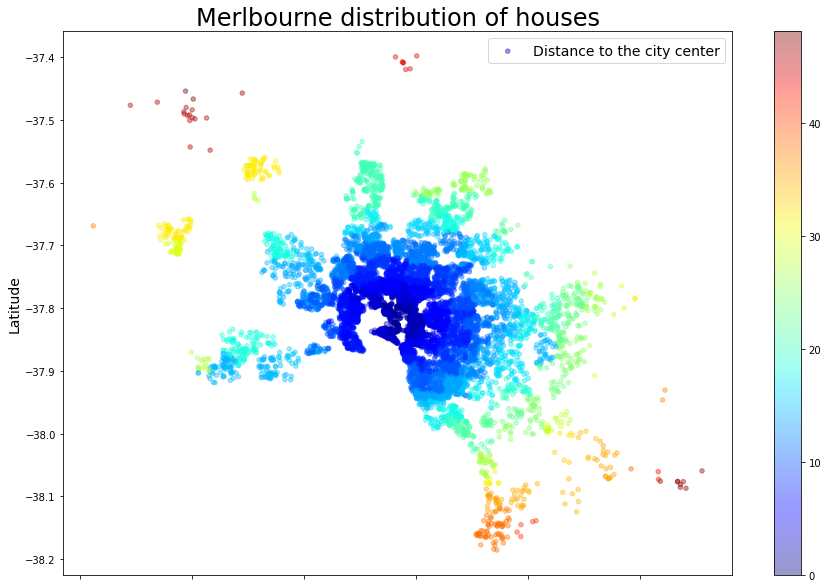

In [7]:
def make_map_merlbourne(dataset):
    dataset.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4, c=dataset.Distance,
                 cmap=plt.get_cmap("jet"), label='Distance to the city center', figsize=(15, 10))
    plt.ylabel("Latitude", fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Merlbourne distribution of houses',fontsize=24)
    plt.show()

make_map_merlbourne(dataset)

Per visualitzar i analitzar la correlació entre les diferents característiques i l'atribut objectiu de la predicció, el preu generem la matriu de correlació de pearson:  

<Figure size 432x288 with 0 Axes>

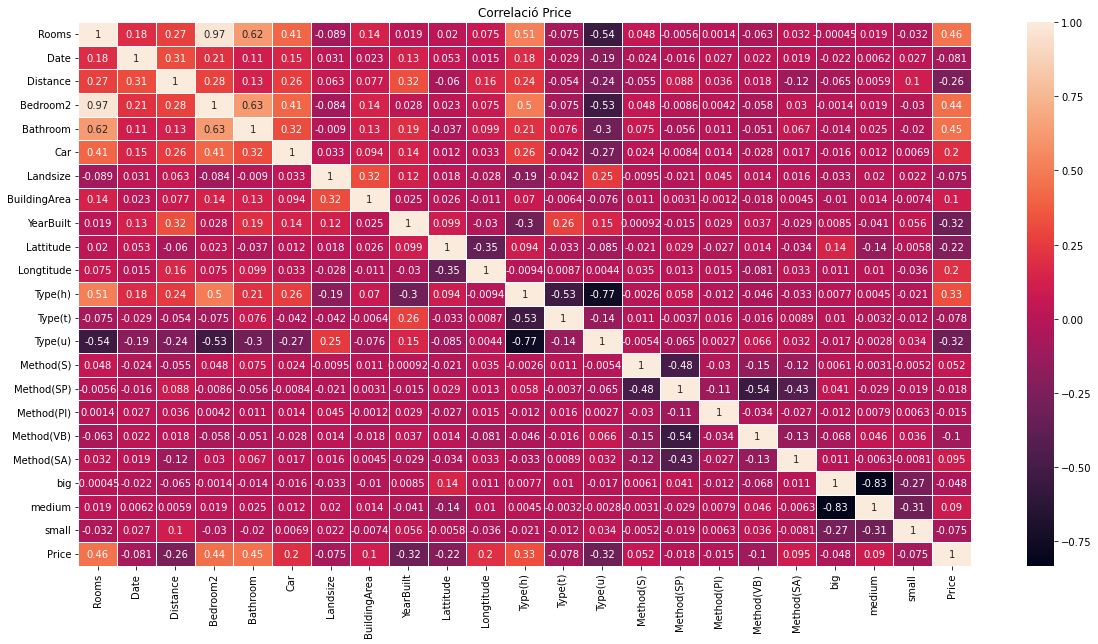

In [8]:
def correlacio_pearson(dataset):
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, 10))  # per mida cel·les
    plt.title("Correlació Price")
    sns.heatmap(dataset.corr(), annot=True, linewidths=.5, ax=ax)
    plt.show()
    
correlacio_pearson(dataset)

Podem observar en la matriu de correlació generada que com els atributs Rooms, Bedroom2, Bathroom i Type(h) són els que tenen una correlació major respecte de Price. Que l'atribut Distance no obtingui una alta correlació es pot deure a la heterogeneïtat dels immobles venuts.

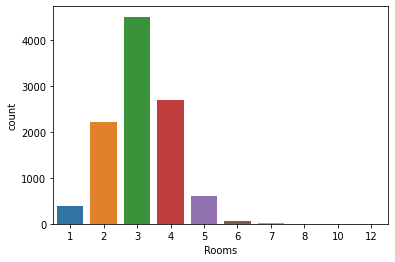

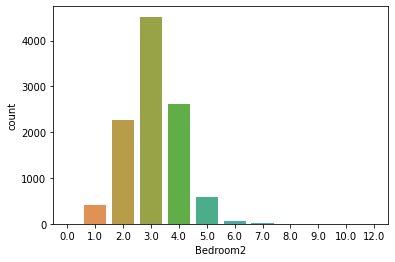

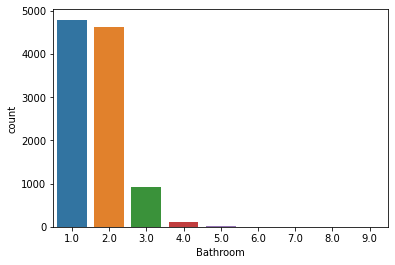

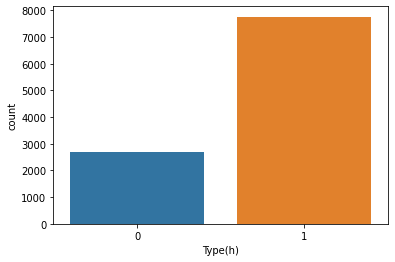

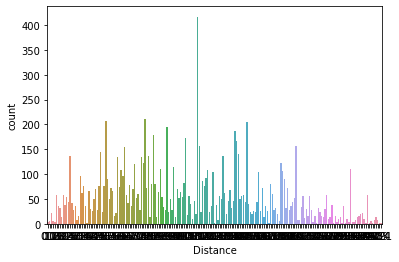

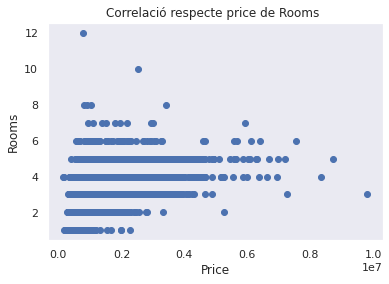

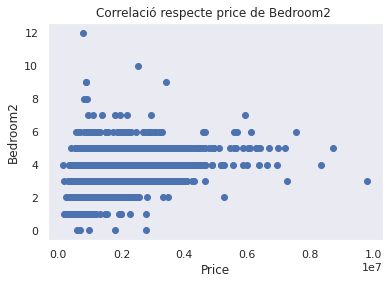

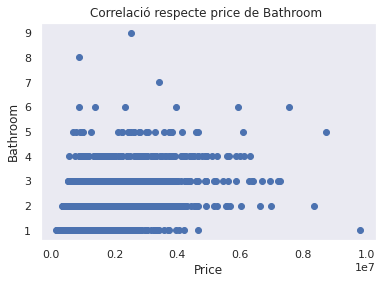

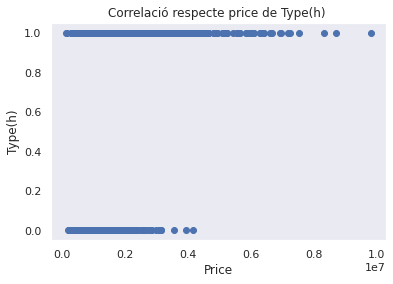

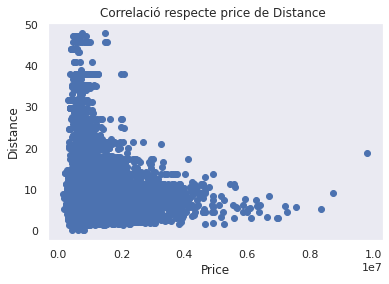

In [9]:
l= ['Rooms', 'Bedroom2', 'Bathroom', 'Type(h)', 'Distance']
for i in l:
    plt.figure()
    sns.countplot(x=i, data=dataset)
    plt.show()

atributs =  ['Rooms', 'Bedroom2', 'Bathroom', 'Type(h)','Distance']   
def estandaritzar_mitjana(dataset):
    return (dataset - dataset.mean(0)) / dataset.std(0)

def make_pairplot_per_atribute(dataset, atributes):
    for atr in atributes:
        sns.set_theme('notebook', style='dark')
        #sns.pairplot(dataset[[atr]], height=5).fig.suptitle("Correlació Gausiana: {}".format(atr), y=1)
        #plt.show()
        plt.figure()
        plt.title("Correlació respecte price de {} ".format(atr))
        plt.scatter(dataset['Price'], dataset[atr])
        plt.ylabel(atr)
        plt.xlabel('Price')
        plt.show()

make_pairplot_per_atribute(dataset,atributs)

### Conclusions:
- La distribució de valors pels atributs amb més correlació es troba en un rang acotat entre 3 o 4 diferents a excepció de l'atribut característica. 
- Com que la variació dels valors Price és molt major no permeten per si sols correlacionar el valro de la variable objectiu.
- Tot i no estar correlacionada amb Price, la característica Distance si que suposa un factor que limita el valor dels immobles ja que com s'aprecia en l'última gràfica de la relació Distancie/Price els preus més alts es troben sempre a una distància menor del centre.

# 4. Classificació
Per tal de procedir a utilitzar els algorismes d'entrenament de models caldran unes funcions prèvies:

In [10]:
def mse(v1, v2):
    return ((v1 - v2) ** 2).mean()


def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()
    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)
    # Retornem el model entrenat
    return regr


def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t


# Dividim dades en 80% train i 20½ Cvalidation
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0] * train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:]
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val



En aquest treball s'ha utilitzat els següents models regressors:
- Regressor Lineal
- Regressor Random Forest
- Regressor Decision Tree

LinealReg R2 mean with k-2:  0.531778  (0.015465)
LinealReg R2 mean with k-3:  0.406275  (0.238040)
LinealReg R2 mean with k-4:  0.293375  (0.491039)
LinealReg R2 mean with k-6:  0.380083  (0.422728)
LinealReg R2 mean with k-10:  0.478459  (0.266230)
LinealReg R2 mean with k-15:  0.458445  (0.424482)
LinealReg R2 mean with k-20:  0.466211  (0.434371)


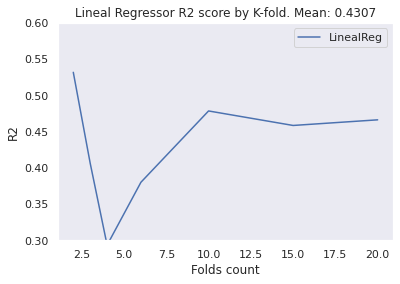

Lineal Regressor R2 score by K-fold. Mean: 0.4307


In [11]:

def regressor_lineal(dataset):
    dataset_norm = standarize(dataset)
    data = dataset_norm.values
    x_data = data[:, :-1]
    y_data = data[:, -1]

    resultat = []; plt.figure(); res_tmp = []; i_index = [2, 3, 4, 6, 10, 15, 20]
    for i in i_index:
        K_Fold = model_selection.KFold(n_splits=i, random_state=random.randint(0, 99), shuffle=True)
        cv_results = model_selection.cross_val_score(LinearRegression(), x_data, y_data, cv=K_Fold)
        message = "%s:  %f  (%f)" % ('LinealReg R2 mean with k-{}'.format(i), cv_results.mean(), cv_results.std())
        print(message)
        res_tmp.append(cv_results.mean())

    resultat.append(res_tmp)
    plt.plot(i_index, res_tmp, label='{}'.format('LinealReg'))
    plt.ylim(0.3, 0.6)
    plt.legend()
    plt.xlabel('Folds count')
    plt.ylabel('{}'.format('R2'))
    plt.title('Lineal Regressor {} by K-fold. Mean: {}'.format('R2 score', round(statistics.mean(res_tmp),4)))
    # plt.savefig("../figures/model_{}_kfoldB".format(type_score))
    plt.show()
    print('Lineal Regressor {} by K-fold. Mean: {}'.format('R2 score',round(statistics.mean(res_tmp),4)))

regressor_lineal(dataset[atributs_correlació])

Random Forest (max dp:30) R2 mean with k-2:  0.795125  (0.002668)
Random Forest (max dp:30) R2 mean with k-3:  0.807252  (0.023728)
Random Forest (max dp:30) R2 mean with k-4:  0.811265  (0.026587)
Random Forest (max dp:30) R2 mean with k-6:  0.811450  (0.027634)
Random Forest (max dp:30) R2 mean with k-10:  0.813556  (0.028641)
Random Forest (max dp:30) R2 mean with k-15:  0.818806  (0.041202)
Random Forest (max dp:30) R2 mean with k-20:  0.819605  (0.046684)


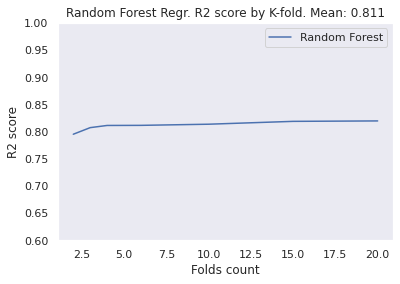

Random Forest Regressor R2 score by K-fold. Mean: 0.811
Random Forest best test R2: 0.841


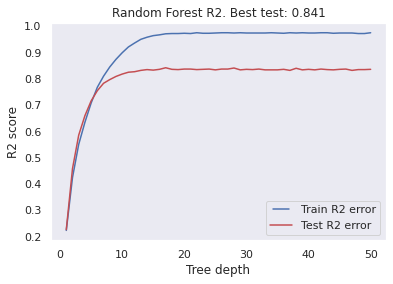

In [12]:

def random_forest(dataset):
    dataset_norm = standarize(dataset)
    data = dataset_norm.values
    x_data = data[:, :-1]
    y_data = data[:, -1]
    x_train, y_train, x_val, y_val = split_data(x_data, y_data)

    # R2 en funció del K-fold
    resultat = [];
    plt.figure();
    res_tmp = [];
    i_index = [2, 3, 4, 6, 10, 15, 20]
    
    for i in i_index:
        K_Fold = model_selection.KFold(n_splits=i, random_state=random.randint(0, 99), shuffle=True)
        cv_results = model_selection.cross_val_score(RandomForestRegressor(max_depth=30), x_data, y_data, cv=K_Fold)
        message = "%s:  %f  (%f)" % (
        'Random Forest (max dp:30) R2 mean with k-{}'.format(i), cv_results.mean(), cv_results.std())
        print(message)
        res_tmp.append(cv_results.mean())

    resultat.append(res_tmp)
    plt.plot(i_index, res_tmp, label='{}'.format('Random Forest'))
    plt.ylim(0.6, 1.0)
    plt.legend()
    plt.xlabel('Folds count')
    plt.ylabel('{}'.format('R2 score'))
    plt.title('Random Forest Regr. {} by K-fold. Mean: {}'.format('R2 score', round(statistics.mean(res_tmp), 4)))
    # plt.savefig("../figures/model_{}_kfoldB".format(type_score))
    plt.show()
    print('Random Forest Regressor {} by K-fold. Mean: {}'.format('R2 score',round(statistics.mean(res_tmp), 4)))
    
    # R2 en funció de max_depth
    max_depths = np.linspace(1, 50, 50, endpoint=True)
    train_results = []
    test_results = []
    for i in max_depths:
        dt = RandomForestRegressor(max_depth=i)        
        dt.fit(x_train, y_train)        
        predicted = dt.predict(x_train)
        r2 = round(r2_score(y_train, predicted), 3)
        train_results.append(r2)

        predicted = dt.predict(x_val)
        r2 = round(r2_score(y_val, predicted), 3)
        test_results.append(r2)

    print('Random Forest best test R2:',max(test_results))
    line1, = plt.plot(max_depths, train_results, 'b', label='Train R2 error')
    line2, = plt.plot(max_depths, test_results, 'r', label='Test R2 error')

    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('R2 score')
    plt.xlabel('Tree depth')
    plt.title('Random Forest R2. Best test: {}'.format(max(test_results)))
    plt.show()

random_forest(dataset[atributs_correlació])


Decision Tree (max dp:30) R2 mean with k-2:  0.617179  (0.014653)
Decision Tree (max dp:30) R2 mean with k-3:  0.605309  (0.034599)
Decision Tree (max dp:30) R2 mean with k-4:  0.619798  (0.065776)
Decision Tree (max dp:30) R2 mean with k-6:  0.632507  (0.035952)
Decision Tree (max dp:30) R2 mean with k-10:  0.636889  (0.049727)
Decision Tree (max dp:30) R2 mean with k-15:  0.624364  (0.077048)
Decision Tree (max dp:30) R2 mean with k-20:  0.616850  (0.068448)


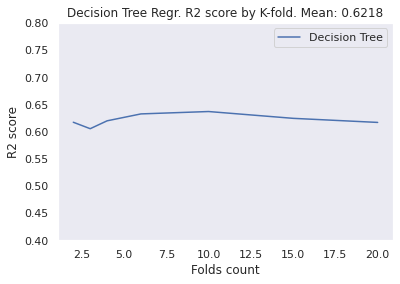

Decision Tree Regressor R2 score by K-fold. Mean: 0.6218
Decision Tree best test R2: 0.705


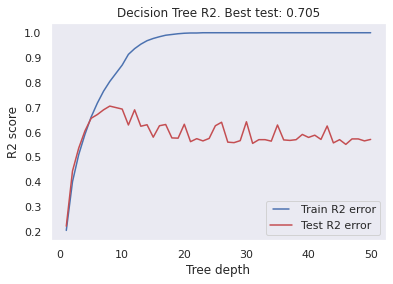

In [13]:
def decision_tree(dataset):
    dataset_norm = standarize(dataset)
    data = dataset_norm.values
    x_data = data[:, :-1]
    y_data = data[:, -1]
    x_train, y_train, x_val, y_val = split_data(x_data, y_data)

    # R2 en funció del K-fold
    resultat = [];
    plt.figure();
    res_tmp = [];
    i_index = [2, 3, 4, 6, 10, 15, 20]
    for i in i_index:
        K_Fold = model_selection.KFold(n_splits=i, random_state=random.randint(0, 99), shuffle=True)
        cv_results = model_selection.cross_val_score(DecisionTreeRegressor(max_depth=30), x_data, y_data, cv=K_Fold)
        message = "%s:  %f  (%f)" % ('Decision Tree (max dp:30) R2 mean with k-{}'.format(i), cv_results.mean(), cv_results.std())
        print(message)
        res_tmp.append(cv_results.mean())

    resultat.append(res_tmp)
    plt.plot(i_index, res_tmp, label='{}'.format('Decision Tree'))
    plt.ylim(0.4, 0.8)
    plt.legend()
    plt.xlabel('Folds count')
    plt.ylabel('{}'.format('R2 score'))
    plt.title('Decision Tree Regr. {} by K-fold. Mean: {}'.format('R2 score', round(statistics.mean(res_tmp), 4)))
    # plt.savefig("../figures/model_{}_kfoldB".format(type_score))
    plt.show()
    print('Decision Tree Regressor {} by K-fold. Mean: {}'.format('R2 score',round(statistics.mean(res_tmp), 4)))

    #R2 en funció de max_depth

    max_depths = np.linspace(1, 50, 50, endpoint=True)
    train_results = []
    test_results = []
    for i in max_depths:
        dt = DecisionTreeRegressor(max_depth=i)
        dt.fit(x_train, y_train)
        predicted = dt.predict(x_train)
        r2 = round(r2_score(y_train, predicted), 3)
        train_results.append(r2)

        predicted = dt.predict(x_val)
        r2 = round(r2_score(y_val, predicted), 3)
        test_results.append(r2)

    print('Decision Tree best test R2:', max(test_results))
    line1, = plt.plot(max_depths, train_results, 'b', label='Train R2 error')
    line2, = plt.plot(max_depths, test_results, 'r', label='Test R2 error')

    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('R2 score')
    plt.xlabel('Tree depth')
    plt.title('Decision Tree R2. Best test: {}'.format(max(test_results)))
    plt.show()


decision_tree(dataset[atributs_correlació])

### Resultats
Entre els diferents models generats en aquest treball, els models de Random Forest Regressor han donat les millors prediccions. El resultats del coeficient de determinació R2 d'aquests models han estat força consistents entorn al 0.8. Pel què fa als models de tipus Decision Tree regressor, ho han estat entorn al 0.7. Finalment, els pitjors resultats els han donat el Regressor Lineal amb entorn a 0.6 d'R2 score. L'avantatge del Random Forest radica en l'ús de diferents subsets de les mostres per entrenar diferents arbres de decisió i  utilitzar la mitjana de les seves prediccions. D'aquesta forma aconsegueix millorar els resultats de la predicció i controlar l'overfiting respecte a un únic arbre sobre tot el dataset. La contrapartida d'aquest model és que al fer un ensemble, el seu cost computacional és molt superiror i fer els experiments amb ell requereix força temps.

# Conclusions
*A part dels models entrenats amb les dades processades que s'han visualitzat en aquest notebook, també s'ha realitzat l'entrenament dels mateixos però amb les dades processades simplement eliminant les totes les mostres amb valors null.

Recull dels models creats per cada dataset amb el millors paràmetres i resultats (valors d'una execució diferent):

| Model            | Dataset | Hiperparametres | Mètrica   | Temps |
|------------------|---------|-----------------|-----------|-------|
| Regressor Lineal | EDA     | default         | R2: 0.57  | 6 ms  |
| Regressor Lineal | FULL    | default         | R2: 0.6   | 3 ms  |
| Random Forest    | EDA     | max_depth: 35   | R2: 0.809 | 3.42s |
| Random Forest    | FULL    | max_depth: 30   | R2: 0.774 | 2.25s |
| Decision Tree    | EDA     | max_depth: 7    | R2: 0.682 | 29ms  |	
| Decision Tree    | FULL    | max_depth: 8    | R2: 0.717 | 22ms  |




Comparant els resultats dels models entre els entrenats sobre el dataset sense substitució de Nan, Full, i el pre-processat amb substitució, EDA, podem observar com l'increment aconseguit d'un 20% de les mostres no aporta una millora en les prediccions dels models ja que s'obtenen resultats semblants. D'aquest fet podem extreure'n dues conclusions. La primera és que el volum de mostres de 8800 del Full és suficientment representativa de tots els possibles habitatges que es poden vendre a la ciutat i augmentar la quantitat de mostres només aporta solapament de mostres. La segona, és que un dels perills de substituir valors desconeguts és generar informació errònia que faci equivocar els models en el seu entrenament. Al haver aconseguit resultats semblants, podem considerar que els substitucions van ser correctes i no van inserir valors errònis en les mostres tractades.

Que no s'hagi pogut aconseguir uns resultats millors amb cap regressor aplicat sobre aquest dataset indica que la variable objectiu, el preu dels habitatges, es veu influenciada per altres factors que no estan recollits en el dataset com poden ser l'estat de l'immoble, si està reformat, si es ven amb els mobles, si disposa  d'equipaments municipals o accéssos a vies de comunicació o parcs en les proximitats.  Per aconseguir unes millors prediccions caldria dotar les mostres de més característiques que recollísin la totalitat dels factors que realment acaben determinant el valor de venda d'un immoble en la ciutat de Melbourne.

La major part dels treballs realitzats amb aquest Kaggle es centren en la part de tractament de Nan i l'anàlisi de les dades. Pels que van un pas més enllà i generen models de predicció, la majoria opta per treballar amb el dataset simplificat i aconsegueixen R2 escort d'entre 0.4 i el 0.7*. El treball amb el dataset més extens i l'ús del Random Forest Regressor ha permés aconseguir uns resultats millors. 

Que no s'hagi pogut aconseguir uns resultats millors amb cap regressor aplicat sobre aquest dataset indica que la variable objectiu, el preu dels habitatges, es veu influenciada per altres factors que no estan recollits en el dataset com poden ser l'estat de l'immoble, si està reformat, si es ven amb els mobles, si disposa  d'equipaments municipals o accéssos a vies de comunicació o parcs en les proximitats.  Per aconseguir unes millors prediccions caldria dotar les mostres de més característiques que recollísin la totalitat dels factors que realment acaben determinant el valor de venda d'un immoble en la ciutat de Melbourne.

*Links altres treballs:
- **[Melbourne Housing]** (https://www.kaggle.com/tracyporter/melbourne-housing)
- **[Melbourne House Price Prediction]** (https://www.kaggle.com/muskanjha/melbourne-house-price-prediction)
- **[Melbourne Housing Market EDA and Regression]** (https://www.kaggle.com/stephaniestallworth/melbourne-housing-market-eda-and-regression#DATA-PRE-PREPROCESSING)